# $$ Sarsa (\lambda)$$

## Imports

In [1]:
# imports from libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os
from collections import defaultdict


# imports from project
from utils.plotting import plot_line_graphs_overlayed
from utils.file_management import create_folder_structure
from utils.file_management import save_nparray_to_folder

## Setting Saving Directory

In [2]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"results","SARSA_LAMBDA")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA'

## Constants

In [3]:
# Initialize the "maze" environment
env = gym.make("maze-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 1000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
RENDER_MAZE = False
ENABLE_RECORDING = False

'''
Sarsa Lambda Related Constants
'''

DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.3
EPSILON = 1
EPSILON_DECAY = 0.999
LAMBDA_VAL_TRACE_DECAY_LIST = [0,0.2,0.4,0.6,0.8,1.0]


'''
CREATING RESULTS SAVING FOLDERS
'''
SAVING_RESULTS_IMAGE_FODLER = os.path.join(SAVING_RESULTS_FODLER,"images")
SAVING_RESULTS_VIDEO_FODLER = os.path.join(SAVING_RESULTS_FODLER,"videos")
SAVING_RESULTS_ARRAY_FODLER = os.path.join(SAVING_RESULTS_FODLER,"arrays")
create_folder_structure(SAVING_RESULTS_IMAGE_FODLER)
create_folder_structure(SAVING_RESULTS_VIDEO_FODLER)
create_folder_structure(SAVING_RESULTS_ARRAY_FODLER)

'''
ENABLE RECORDING
'''
if ENABLE_RECORDING:
    env = gym.wrappers.Monitor(env,SAVING_RESULTS_VIDEO_FODLER, force=True)
    
    

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Simulation

In [9]:
def simulate(discount_factor:float=0.99,
            learning_rate:float=0.01,
            epsilon:float= 1,
            epsilon_decay:float= 0.999,
            trace_decay:int= 0):


    """Simulate Sarsa Algorythim .

    Args:
        discount_factor (float): gamma.
        epsilon (float): gamma.
        epsilon_decay (float): gamma.
        trace_decay (float): gamma.


    Returns:
        np.array(reward_episode_list): Numpy array with the episodes rewards
        np.array(explore_rate_episode_list): Numpy array with the episodes explore rates
        np.array(learning_rate_episode_list): Numpy array with the episodes learning rates
        np.array(num_streaks_episode_list): Numpy array with the episodes number of mazze completions
        np.array(length_episode_list): Numpy array with the episodes lengths
    """
    
    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []


    # Instantiating the learning related parameters
    #learning_rate = get_learning_rate(0) # alpha
    explore_rate = get_explore_rate(0)
     
    # Render tha maze
    env.render()
    
    #q_table # inicializar ela aqui.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    

    #Initializain num streaks
    num_streaks= 0

    for episode in range(NUM_EPISODES):

 
        # Reset the environment
        obv = env.reset()
        
        # initialize Reward
        total_reward = 0
        
        # initialize episolon decay
        epsilon *= epsilon_decay

        # E(S,A) = 0
        E = defaultdict(lambda: np.zeros(env.action_space.n))
        
        # Initialize state
        state = state_to_bucket(obv)
        
        # initialize action    # VERIFICAR SE SEGUE A POLITICA   
        action = epsilon_greedy_police(state, explore_rate, Q)
        
        for t in range(MAX_T):

            # Select an action
            next_action = epsilon_greedy_police(state, explore_rate, Q)
            
            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            next_state = state_to_bucket(obv)
            total_reward += reward
            
            # current_q
            current_q = Q[state][action] 
            
            # next_q
            next_q = Q[next_state][next_action]
            
            # TD = r + gamma * Q(S', A') - Q(S,A)
            # TD = sigma
            TD = reward + (discount_factor * (next_q) - current_q )
            
            # E(S,A) - E(S,A) + 1
            E[state][action] += 1
            
            #For all s E S, a E A(s)
            for s, _ in Q.items():
                Q[s][:] += learning_rate * TD * E[s][:]
                E[s][:] *= trace_decay * discount_factor


            #S - S'
            state = next_state
            
            # A - A'
            action = next_action
            

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print(f"Episode {episode} finished after {t} time steps with total reward = {total_reward} (streak {num_streaks}).")

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print(f"Episode {episode} timed out at {t} with total reward = {total_reward}.")

        

        # Appending Episode values to the list
        reward_episode_list.append(total_reward)
        explore_rate_episode_list.append(explore_rate)
        num_streaks_episode_list.append(num_streaks)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)


    return (Q,np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))

## Epsilon Greed Exploration

In [5]:
def epsilon_greedy_police(state, explore_rate, q_table):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

## Updating EXPLORE_RATE and LEARNING_RATE

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## Function that returns the actual state

In [7]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

9999999999999 (streak 4).
Episode 645 finished after 19 time steps with total reward = 0.9239999999999999 (streak 0).
Episode 646 finished after 19 time steps with total reward = 0.9239999999999999 (streak 1).
Episode 647 finished after 21 time steps with total reward = 0.9159999999999999 (streak 2).
Episode 648 finished after 23 time steps with total reward = 0.9079999999999999 (streak 3).
Episode 649 finished after 19 time steps with total reward = 0.9239999999999999 (streak 4).
Episode 650 finished after 29 time steps with total reward = 0.8839999999999999 (streak 5).
Episode 651 finished after 19 time steps with total reward = 0.9239999999999999 (streak 0).
Episode 652 finished after 21 time steps with total reward = 0.9159999999999999 (streak 1).
Episode 653 finished after 19 time steps with total reward = 0.9239999999999999 (streak 2).
Episode 654 finished after 21 time steps with total reward = 0.9159999999999999 (streak 3).
Episode 655 finished after 31 time steps with total re

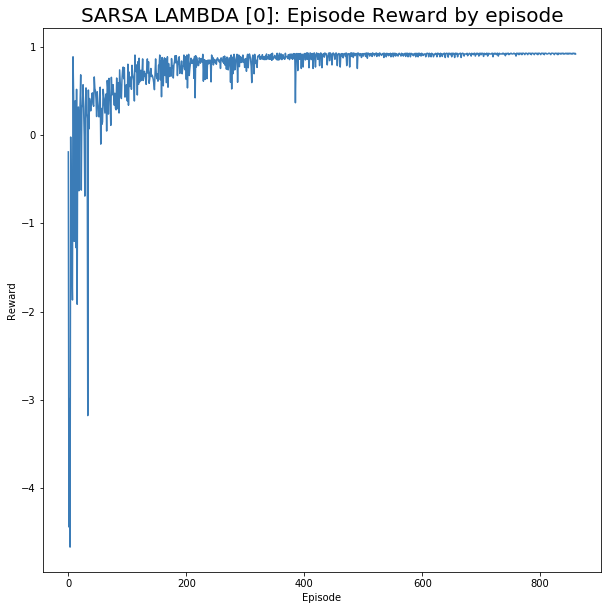

<Figure size 432x288 with 0 Axes>

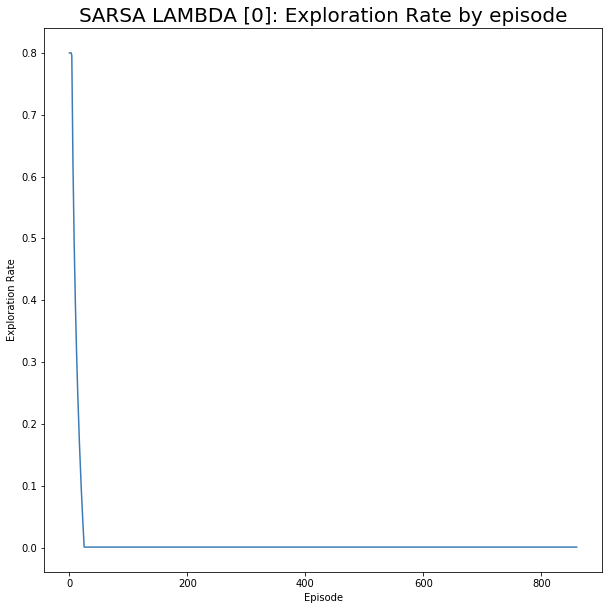

<Figure size 432x288 with 0 Axes>

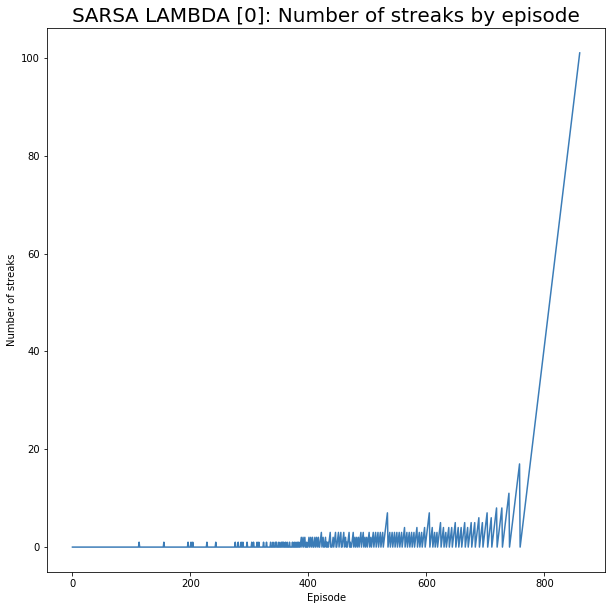

<Figure size 432x288 with 0 Axes>

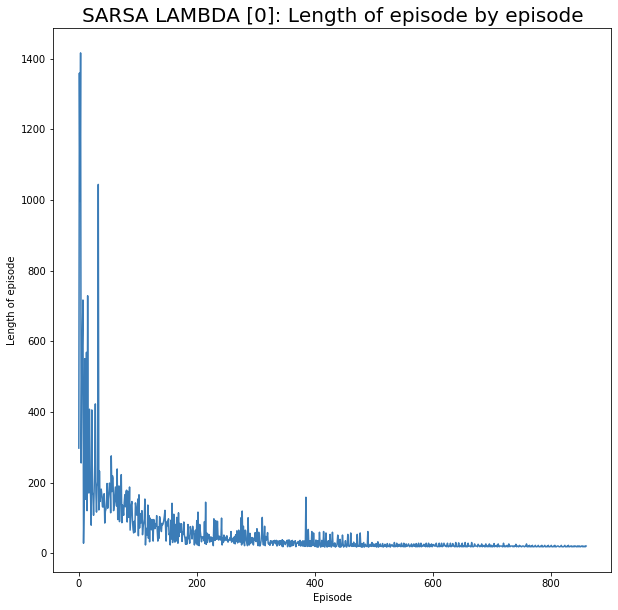

ished after 41 time steps with total reward = 0.8359999999999999 (streak 0).
Episode 321 finished after 45 time steps with total reward = 0.8199999999999998 (streak 0).
Episode 322 finished after 57 time steps with total reward = 0.7719999999999998 (streak 0).
Episode 323 finished after 33 time steps with total reward = 0.8679999999999999 (streak 0).
Episode 324 finished after 40 time steps with total reward = 0.8399999999999999 (streak 0).
Episode 325 finished after 35 time steps with total reward = 0.8599999999999999 (streak 0).
Episode 326 finished after 36 time steps with total reward = 0.8559999999999999 (streak 0).
Episode 327 finished after 26 time steps with total reward = 0.8959999999999999 (streak 0).
Episode 328 finished after 38 time steps with total reward = 0.8479999999999999 (streak 0).
Episode 329 finished after 35 time steps with total reward = 0.8599999999999999 (streak 0).
Episode 330 finished after 38 time steps with total reward = 0.8479999999999999 (streak 0).
Epi

<Figure size 432x288 with 0 Axes>

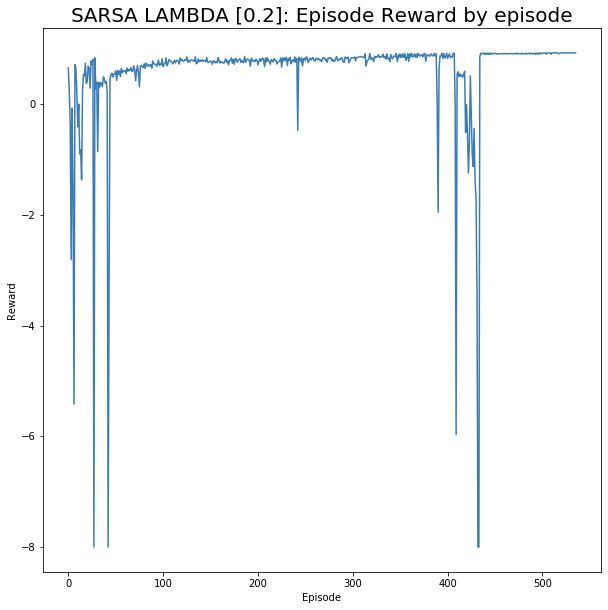

<Figure size 432x288 with 0 Axes>

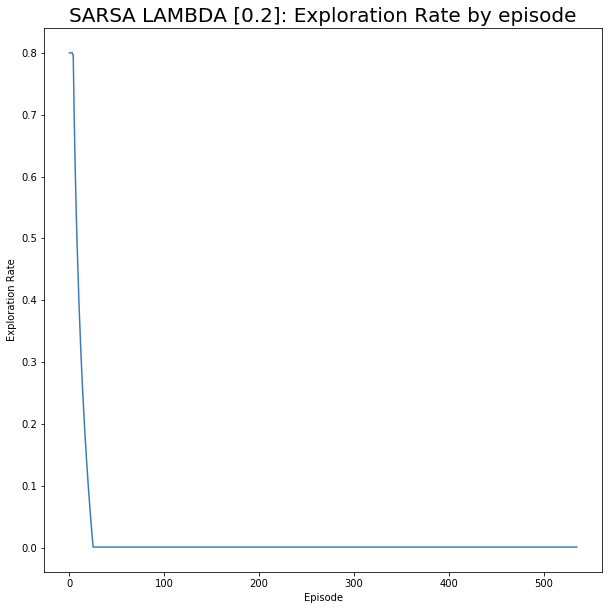

<Figure size 432x288 with 0 Axes>

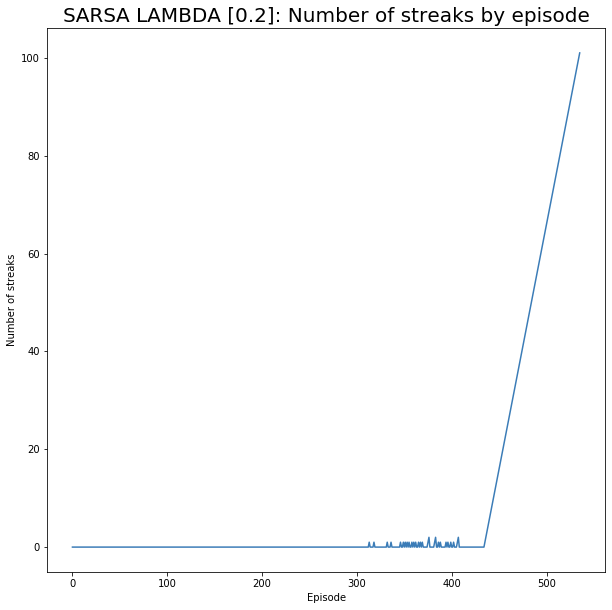

<Figure size 432x288 with 0 Axes>

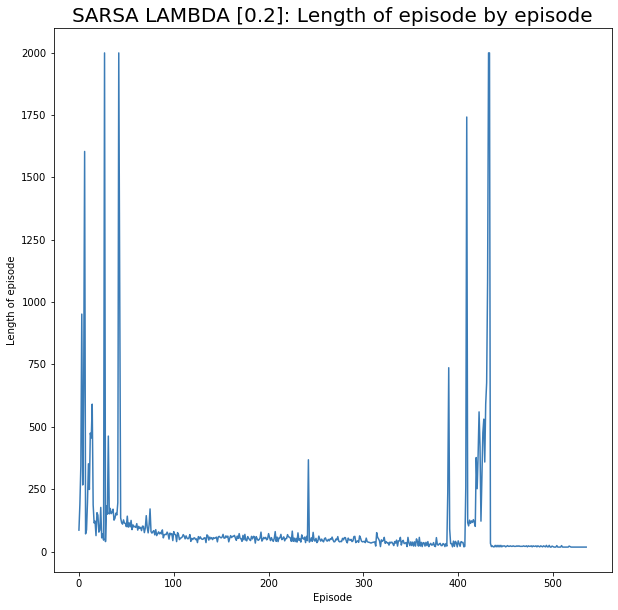

rd = 0.9199999999999999 (streak 0).
Episode 123 finished after 34 time steps with total reward = 0.8639999999999999 (streak 1).
Episode 124 finished after 27 time steps with total reward = 0.8919999999999999 (streak 0).
Episode 125 finished after 17 time steps with total reward = 0.9319999999999999 (streak 0).
Episode 126 finished after 31 time steps with total reward = 0.8759999999999999 (streak 1).
Episode 127 finished after 19 time steps with total reward = 0.9239999999999999 (streak 0).
Episode 128 finished after 29 time steps with total reward = 0.8839999999999999 (streak 1).
Episode 129 finished after 21 time steps with total reward = 0.9159999999999999 (streak 0).
Episode 130 finished after 28 time steps with total reward = 0.8879999999999999 (streak 1).
Episode 131 finished after 19 time steps with total reward = 0.9239999999999999 (streak 0).
Episode 132 finished after 19 time steps with total reward = 0.9239999999999999 (streak 1).
Episode 133 finished after 29 time steps wit

<Figure size 432x288 with 0 Axes>

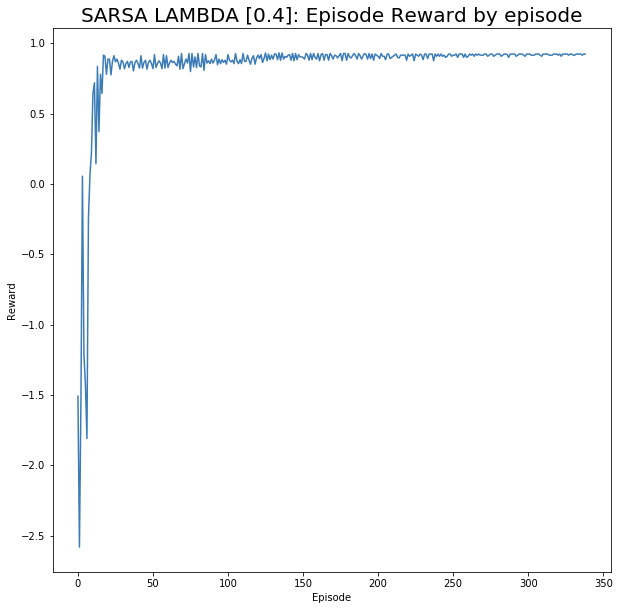

<Figure size 432x288 with 0 Axes>

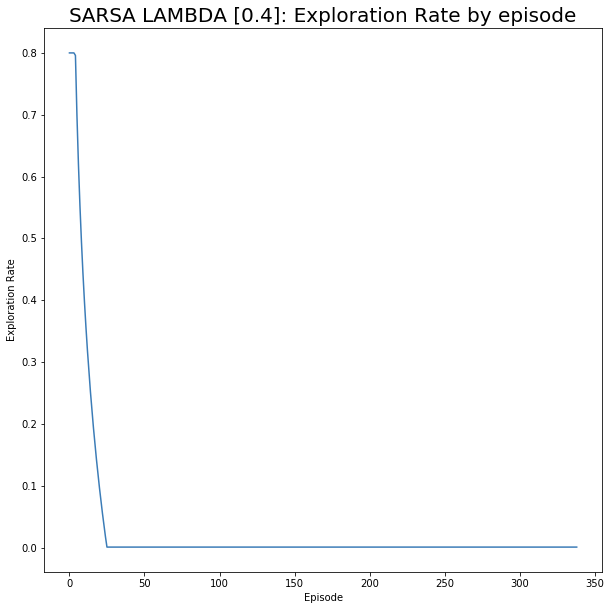

<Figure size 432x288 with 0 Axes>

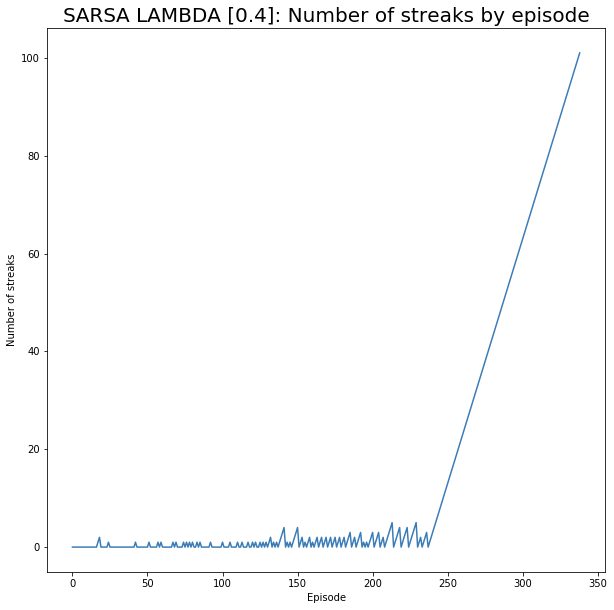

<Figure size 432x288 with 0 Axes>

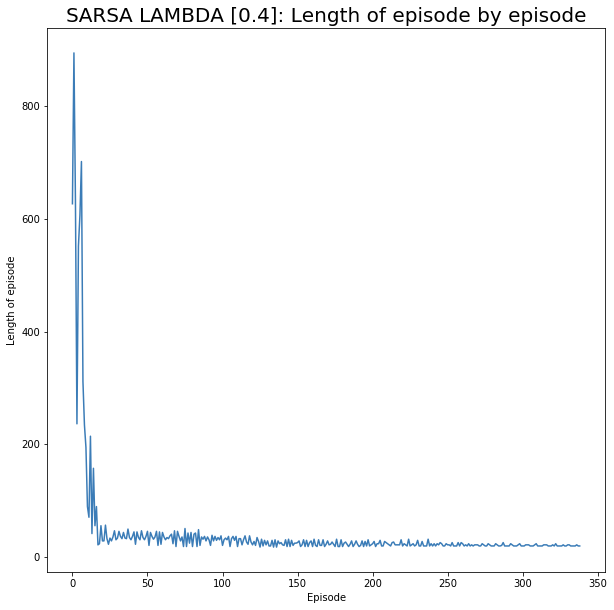

================ Evaluating for LAMBDA = 0.6

Episode 0 finished after 791 time steps with total reward = -2.1640000000000024 (streak 0).
Episode 1 finished after 524 time steps with total reward = -1.0960000000000014 (streak 0).
Episode 2 finished after 1100 time steps with total reward = -3.3999999999999586 (streak 0).
Episode 3 finished after 160 time steps with total reward = 0.35999999999999954 (streak 0).
Episode 4 finished after 434 time steps with total reward = -0.7360000000000013 (streak 0).
Episode 5 finished after 411 time steps with total reward = -0.6440000000000012 (streak 0).
Episode 6 finished after 159 time steps with total reward = 0.36399999999999955 (streak 0).
Episode 7 finished after 175 time steps with total reward = 0.2999999999999995 (streak 0).
Episode 8 finished after 280 time steps with total reward = -0.12000000000000077 (streak 0).
Episode 9 finished after 91 time steps with total reward = 0.6359999999999997 (streak 0).
Episode 10 finished after 96 time s

<Figure size 432x288 with 0 Axes>

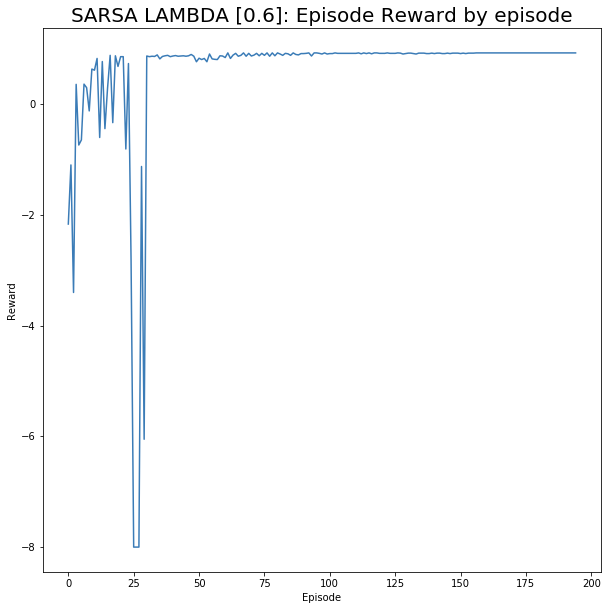

<Figure size 432x288 with 0 Axes>

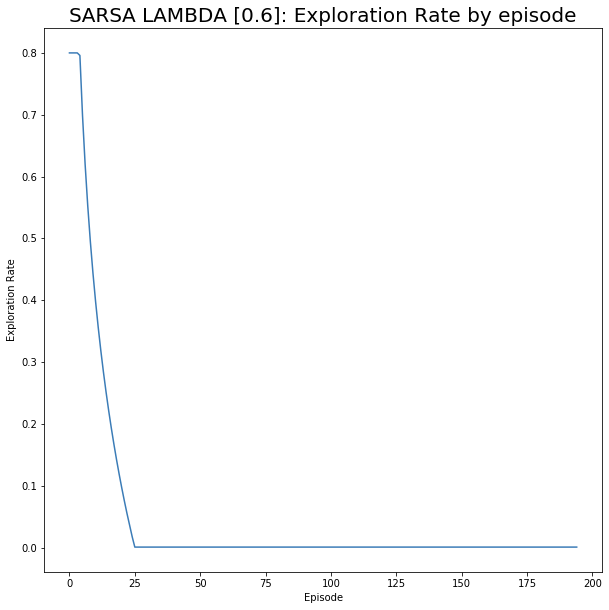

<Figure size 432x288 with 0 Axes>

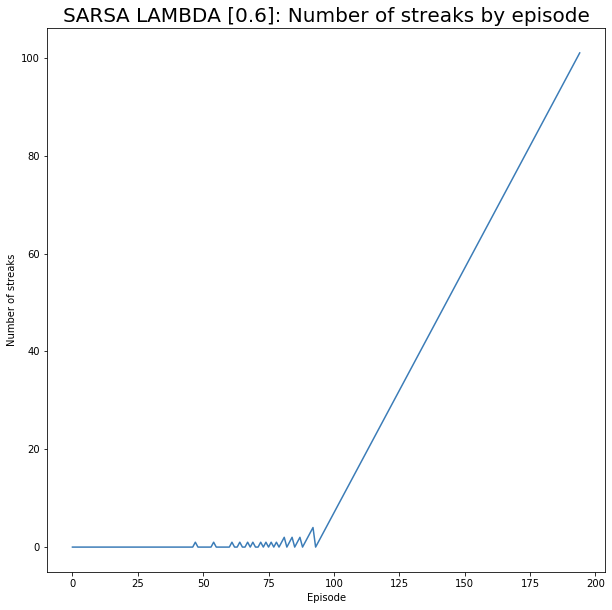

<Figure size 432x288 with 0 Axes>

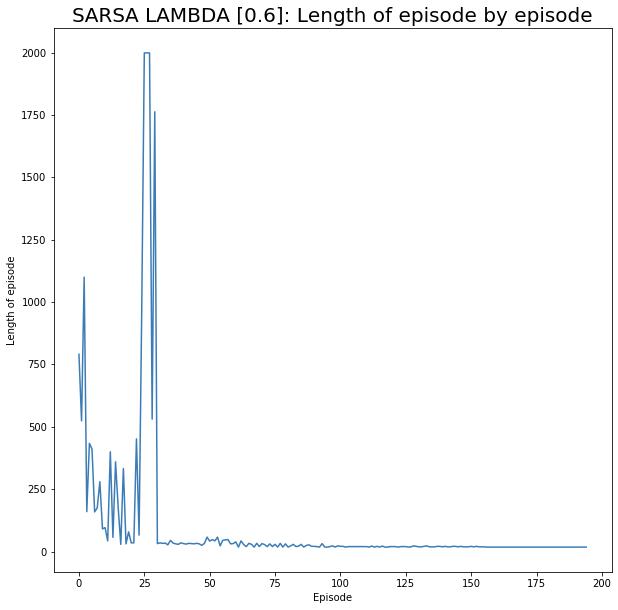

================ Evaluating for LAMBDA = 0.8

Episode 0 finished after 1011 time steps with total reward = -3.043999999999998 (streak 0).
Episode 1 finished after 437 time steps with total reward = -0.7480000000000013 (streak 0).
Episode 2 finished after 494 time steps with total reward = -0.9760000000000015 (streak 0).
Episode 3 finished after 154 time steps with total reward = 0.38399999999999956 (streak 0).
Episode 4 finished after 794 time steps with total reward = -2.1760000000000024 (streak 0).
Episode 5 finished after 230 time steps with total reward = 0.0799999999999993 (streak 0).
Episode 6 finished after 326 time steps with total reward = -0.30400000000000094 (streak 0).
Episode 7 finished after 42 time steps with total reward = 0.8319999999999999 (streak 0).
Episode 8 finished after 29 time steps with total reward = 0.8839999999999999 (streak 0).
Episode 9 finished after 94 time steps with total reward = 0.6239999999999997 (streak 0).
Episode 10 finished after 44 time steps 

<Figure size 432x288 with 0 Axes>

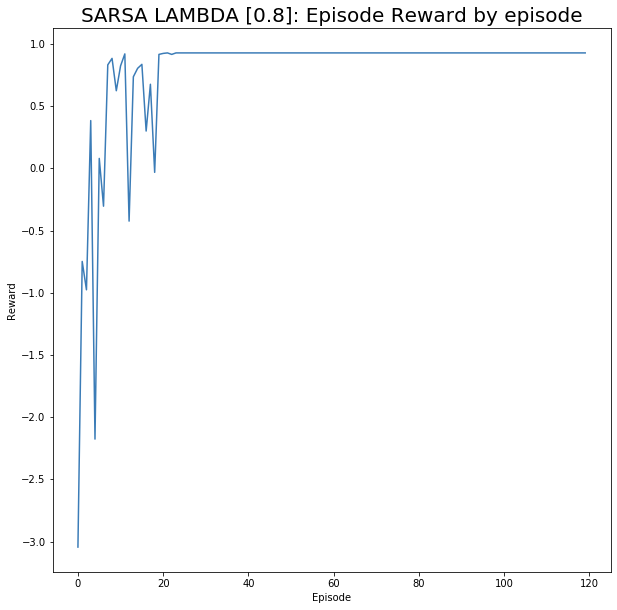

<Figure size 432x288 with 0 Axes>

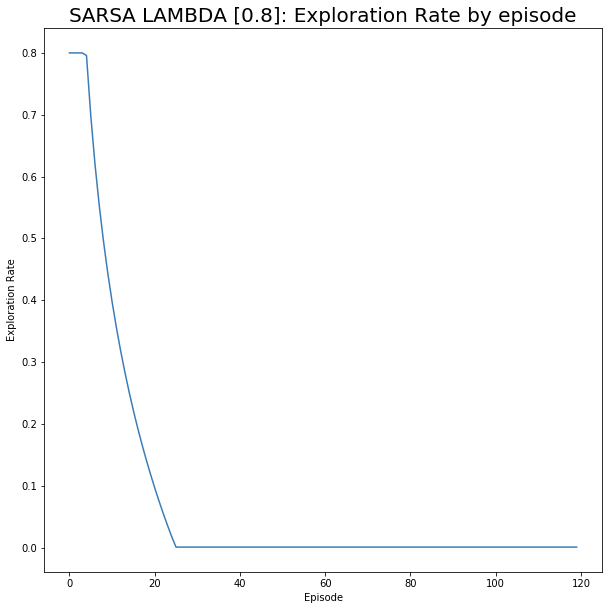

<Figure size 432x288 with 0 Axes>

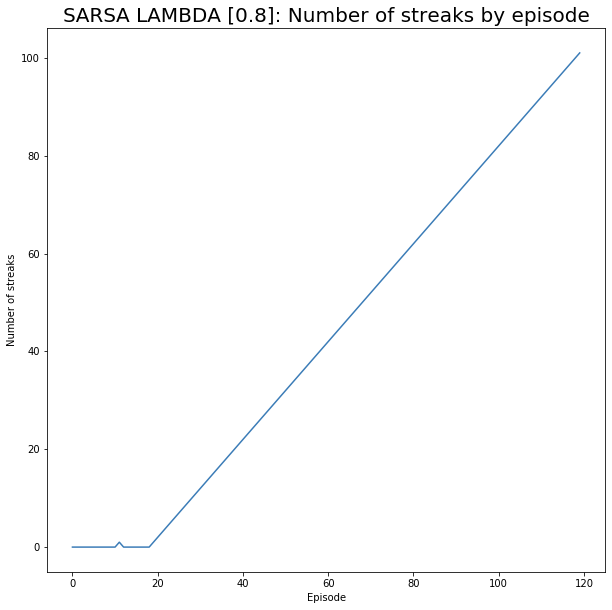

<Figure size 432x288 with 0 Axes>

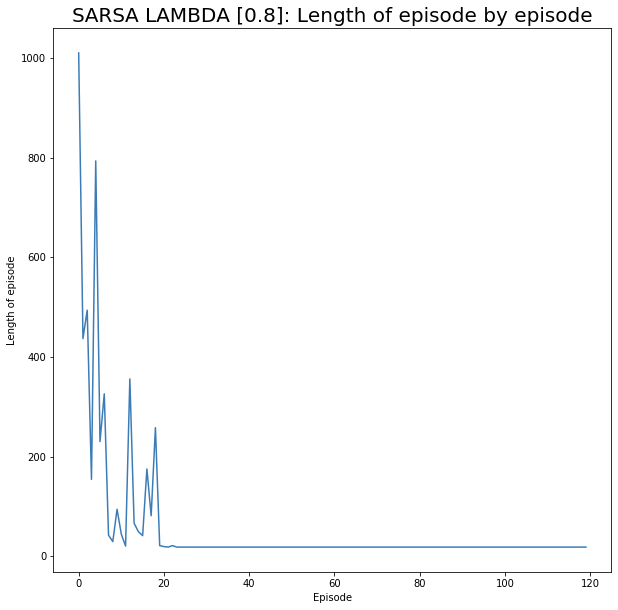

rd = 0.7919999999999998 (streak 0).
Episode 140 finished after 51 time steps with total reward = 0.7959999999999998 (streak 0).
Episode 141 finished after 51 time steps with total reward = 0.7959999999999998 (streak 0).
Episode 142 finished after 51 time steps with total reward = 0.7959999999999998 (streak 0).
Episode 143 finished after 50 time steps with total reward = 0.7999999999999998 (streak 0).
Episode 144 finished after 50 time steps with total reward = 0.7999999999999998 (streak 0).
Episode 145 finished after 49 time steps with total reward = 0.8039999999999998 (streak 0).
Episode 146 finished after 49 time steps with total reward = 0.8039999999999998 (streak 0).
Episode 147 finished after 49 time steps with total reward = 0.8039999999999998 (streak 0).
Episode 148 finished after 48 time steps with total reward = 0.8079999999999998 (streak 0).
Episode 149 finished after 48 time steps with total reward = 0.8079999999999998 (streak 0).
Episode 150 finished after 48 time steps wit

<Figure size 432x288 with 0 Axes>

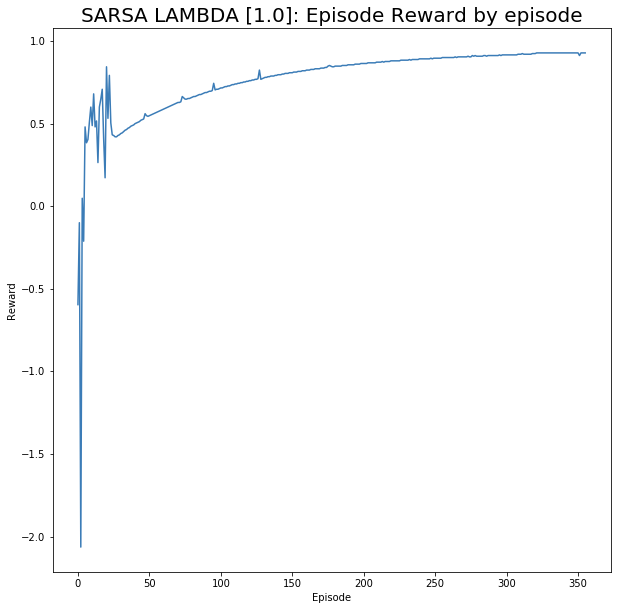

<Figure size 432x288 with 0 Axes>

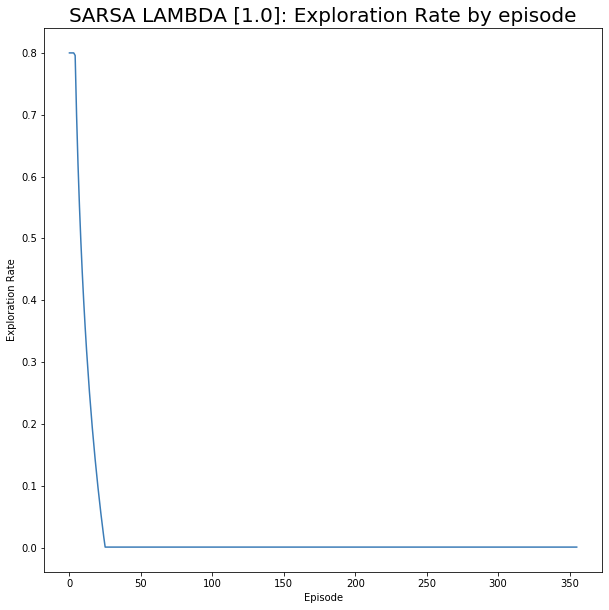

<Figure size 432x288 with 0 Axes>

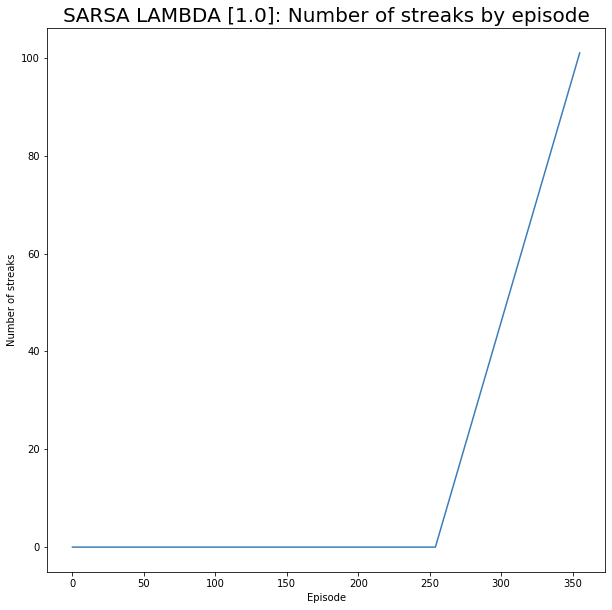

<Figure size 432x288 with 0 Axes>

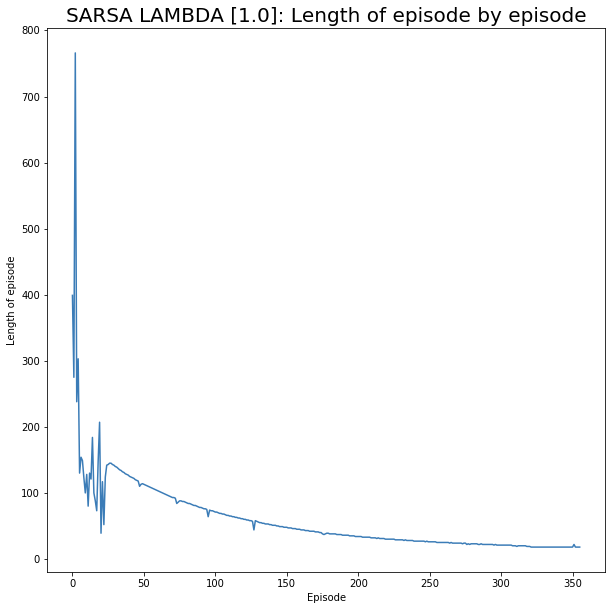

<Figure size 432x288 with 0 Axes>

In [23]:

reward_episode_array_list = []
explore_rate_episode_array_list = []
num_streaks_episode_array_list = []
length_episode_array_list = []
Q_list = []

for i in range(len(LAMBDA_VAL_TRACE_DECAY_LIST)):
        SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY = os.path.join(SAVING_RESULTS_IMAGE_FODLER,str(LAMBDA_VAL_TRACE_DECAY_LIST[i]))

        
        LAMBDA_VAL_TRACE_DECAY = LAMBDA_VAL_TRACE_DECAY_LIST[i]
        print(f"================ Evaluating for LAMBDA = {LAMBDA_VAL_TRACE_DECAY}\n")

        Q,reward_episode_array,explore_rate_episode_array,num_streaks_episode_array,length_episode_array = \
        simulate(discount_factor=DISCOUNT_FACTOR,
                learning_rate=LEARNING_RATE,
                epsilon=EPSILON,
                epsilon_decay=EPSILON_DECAY,
                trace_decay=LAMBDA_VAL_TRACE_DECAY)

        
        reward_episode_array_list.append(reward_episode_array)
        explore_rate_episode_array_list.append(explore_rate_episode_array)
        num_streaks_episode_array_list.append(num_streaks_episode_array)
        length_episode_array_list.append(length_episode_array)
        Q_list.append(Q)


        
        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"reward_episode")
        create_folder_structure(graph_saving_path[0])
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = ["None_Marker"],
                            title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Episode Reward by episode" ,
                                graph_saving_path = graph_saving_path[0])


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"explore_rate_episode")
        create_folder_structure(graph_saving_path[0])
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [explore_rate_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Exploration Rate",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Exploration Rate by episode" ,
                                graph_saving_path = graph_saving_path[0])


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"num_streaks_episode")
        create_folder_structure(graph_saving_path[0])
        plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [num_streaks_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Number of streaks",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Number of streaks by episode" ,
                                graph_saving_path = graph_saving_path[0])


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"length_episode"),
        create_folder_structure(graph_saving_path[0])
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [length_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Length of episode",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Length of episode by episode" ,
                                graph_saving_path = graph_saving_path[0])


                                                                                                        
if ENABLE_RECORDING:
        env.close()

## Saving numpy arrays from results

In [24]:
for i in range(len(LAMBDA_VAL_TRACE_DECAY_LIST)):
    LAMBDA_VAL_FOLDER = os.path.join(SAVING_RESULTS_ARRAY_FODLER,str(LAMBDA_VAL_TRACE_DECAY_LIST[i]))
    create_folder_structure(LAMBDA_VAL_FOLDER)
    save_nparray_to_folder(reward_episode_array_list[i],LAMBDA_VAL_FOLDER,"reward_episode")
    save_nparray_to_folder(explore_rate_episode_array_list[i],LAMBDA_VAL_FOLDER,"explore_rate")
    save_nparray_to_folder(num_streaks_episode_array_list[i],LAMBDA_VAL_FOLDER,"num_streaks")
    save_nparray_to_folder(length_episode_array_list[i],LAMBDA_VAL_FOLDER,"length_episode")

reward_episode Shape:  (861,)
explore_rate Shape:  (861,)
num_streaks Shape:  (861,)
length_episode Shape:  (861,)
reward_episode Shape:  (536,)
explore_rate Shape:  (536,)
num_streaks Shape:  (536,)
length_episode Shape:  (536,)
reward_episode Shape:  (339,)
explore_rate Shape:  (339,)
num_streaks Shape:  (339,)
length_episode Shape:  (339,)
reward_episode Shape:  (195,)
explore_rate Shape:  (195,)
num_streaks Shape:  (195,)
length_episode Shape:  (195,)
reward_episode Shape:  (120,)
explore_rate Shape:  (120,)
num_streaks Shape:  (120,)
length_episode Shape:  (120,)
reward_episode Shape:  (356,)
explore_rate Shape:  (356,)
num_streaks Shape:  (356,)
length_episode Shape:  (356,)


## Value Function

No handles with labels found to put in legend.


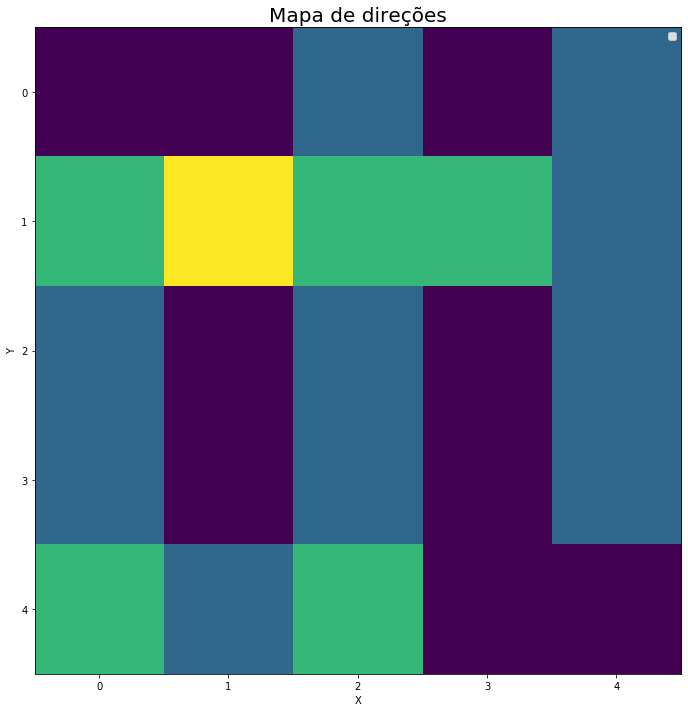

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

grid = np.zeros((5,5))
    
for i in range (5):
    for j in range (5):
        grid[i,j] = np.argmax(Q_list[2][i,j])
        

blue_patch = mpatches.Patch(color='blue', label='Azul - Baixo')
green_patch = mpatches.Patch(color='green', label='Verde - Direita')
yellow_patch = mpatches.Patch(color='yellow', label='Amarelo - Esquerda')
purple_patch = mpatches.Patch(color='purple', label='Roxo - Cima')

plt.legend(handles=[blue_patch,green_patch,yellow_patch,purple_patch])


ax.legend(loc="upper right")
ax.set_xlabel("X",fontsize = 10)
ax.set_ylabel("Y",fontsize = 10)
ax.set_title("Mapa de direções",fontsize = 20)
ax.figure.set_size_inches(10,10)
fig.tight_layout()
plt.imshow(grid.T)  
plt.savefig(f"{SAVING_RESULTS_IMAGE_FODLER}/directions_map")
plt.show()
plt.clf()